# Florida

Now that we've finished analyzing California, let's go ahead and start working on Florida.  Florida has also had a very difficult summer with an exponential increase in positive cases of COVID-19. Let's load up the data and some helper functions. 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import helper_functions
from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import create_dataset
from helper_functions import fit_model
from helper_functions import test_RMSE
from helper_functions import train_RMSE
# from helper_functions import preprocess_data
from helper_functions import plot_loss
from helper_functions import LSTM_prediction_plot
import pmdarima as pm

Using TensorFlow backend.


We're going to go ahead and copy this helper function for use later.

In [3]:
# Instantiate scaler. This will be used later.
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column, scaler):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    import warnings
    warnings.filterwarnings('ignore')
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import MinMaxScaler
    

    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test

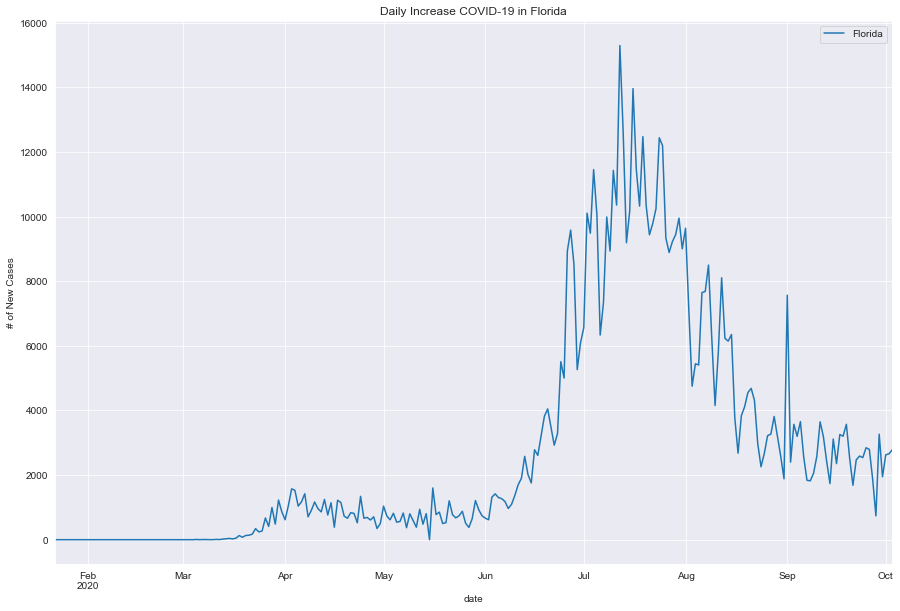

In [5]:
df = pd.read_csv('csv_files/national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# Florida
fl = df['FL_positiveIncrease']
fl.plot(figsize=(15, 10), label='Florida')

plt.ylabel('# of New Cases')
plt.title('Daily Increase COVID-19 in Florida')
plt.legend()
plt.show();


# SARIMA

Just like with California, we're going to **start with a SARIMA model**.  Due to the similar shape of the plot, I'm expecting to see very similar trends and seasonality in Florida, as well.

## (Partial) Autocorrelation and Decomposition

Just like before, we'll **skip checking stationarity** simply because the plot clearly shows a exponential trends, and we'll be able to calculate differencing through grid search.  So for now, let's go ahead and **find values for `p` , `q`, and `s`**.

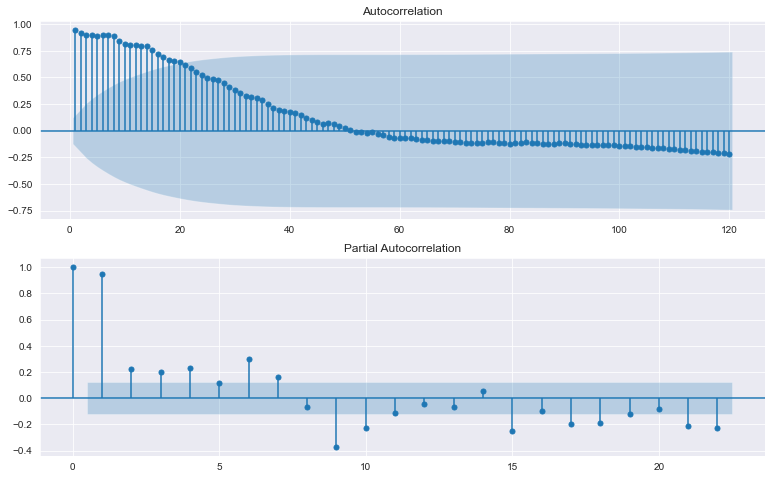

In [4]:
acf_pacf(fl)

These plots are very similar to California's.  Once again the AR(`p`) is around 5 and the MA(`q`) is up to 19 this time around.

Time to find out our seasonality.

## Seasonality

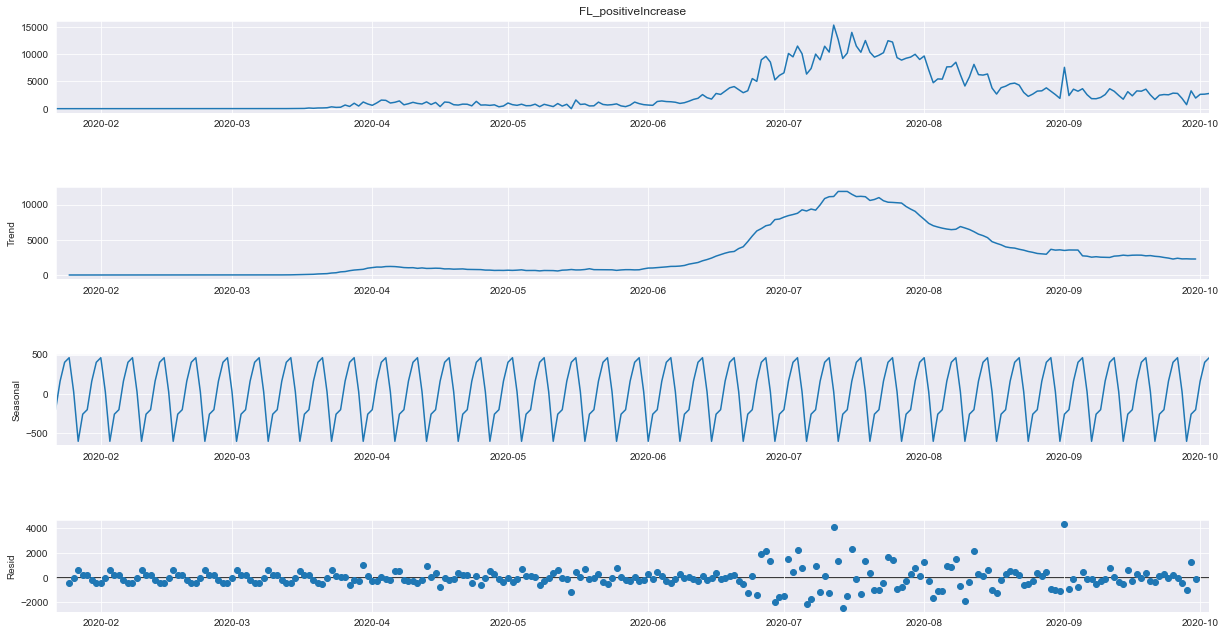

In [5]:
decompose_time_series(fl)

Again, we're seeing similarities between California and Florida (I have a feeling that this will be a theme).  The seasonality is weekly, there is the aforementioned trend is exponentially positive and then exponentially negative, and (while I didn't mention this before) the residuals stay pretty **normal at first**, but then **become heteroskedastic** going into the summer months before they return to normal.   

Now that we have our parameters, let's use Auto ARIMA to find the optimal combination of `pdqs`.

## Grid Search

In [6]:
fl_results = pm.auto_arima(fl,information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=6, max_q=22,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
fl_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4281.882, BIC=4303.130, Fit time=0.433 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4314.190, BIC=4321.272, Fit time=0.013 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=4280.730, BIC=4294.895, Fit time=0.103 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4268.715, BIC=4282.880, Fit time=0.290 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4239.586, BIC=4257.293, Fit time=0.622 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 7); AIC=4254.120, BIC=4268.285, Fit time=0.390 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=4239.624, BIC=4260.871, Fit time=1.121 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4287.246, BIC=4297.870, Fit time=0.078 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 2, 7); AIC=4238.134, BIC=4262.923, Fit time=1.243 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 1, 4),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(2, 0, 0, 7), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

Alright! Our optimal order is (2, 1, 4) and the seasonal order is (2, 0, 0, 7).  The AIC score for this combination is 4230.197 meaning that it's pretty complex (I've certainly seen worse).  This could be necessary, though, considering that our entire dataset contains only 256 samples.  

Let's split up the data now.

## Train-Test Split and Modeling

In [7]:
# Function performs an 80/20 split
fl_train, fl_test = train_test(fl)

The data has been split, so now we'll fit the model to our training data

                                     SARIMAX Results                                      
Dep. Variable:                FL_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(2, 1, 4)x(2, 0, [], 7)   Log Likelihood               -1674.225
Date:                            Thu, 15 Oct 2020   AIC                           3366.450
Time:                                    15:52:57   BIC                           3396.313
Sample:                                01-22-2020   HQIC                          3378.530
                                     - 08-13-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0458      0.061     -0.755      0.450      -0.165       0.073
ar.L2          0.8134      0.054   

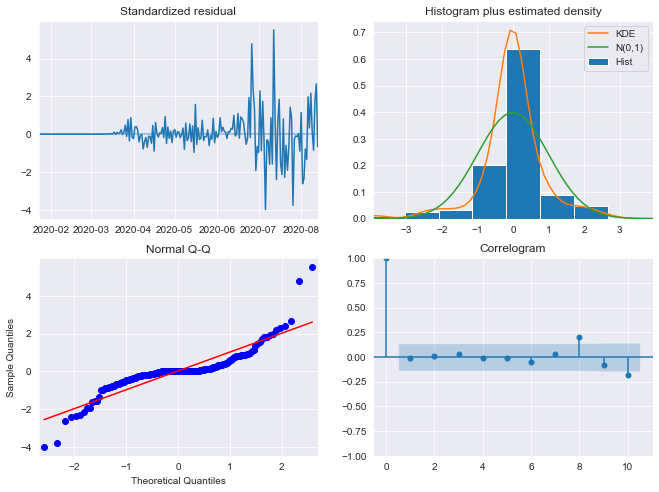

In [8]:
pdq = (2, 1, 4)
pdqs = (2, 0, 0, 7)
results = fit_model(fl_train, pdq=pdq, pdqs=pdqs)

## Results 

The residuals are still **heteroskedastic**. The histogram is pretty symmetrical (like with California's), but is **Leptokurtic** making it very peaky.

As for our coefficients, all of them are **statistically significant** (p-value < 0.05) with the **exception of the Autoregression at lag 1**.  This could mean that we should **drop AR(1)** and **jump straight to AR(2)**.  This is the first major distinction between California and Florida.  Before we go out and create a custom ARMA model to skip AR(1), we'll check out the effectiveness of0 our LSTM model.


First: Time to Check the RMSE for our Train and Test sets.

## Train and Test RMSE

SARIMA model RMSE on train data: 1598.55841


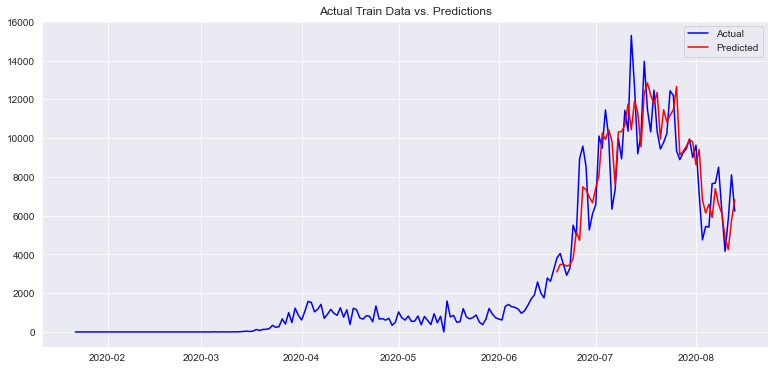

In [10]:
train_RMSE(fl_train, results, display = True)

SARIMA model RMSE on test data: 1082.76225


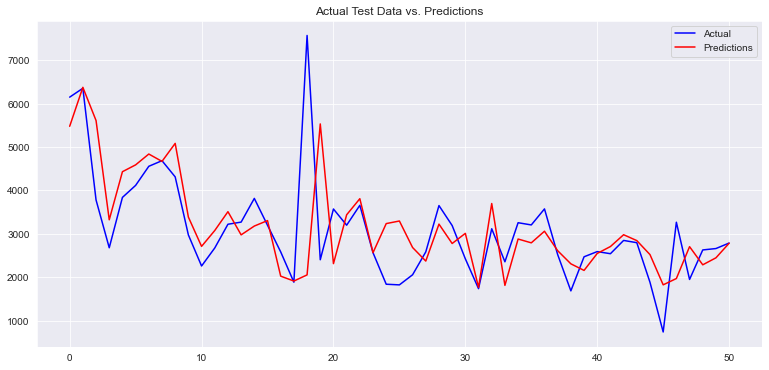

In [11]:
test_RMSE(fl_train, fl_test, pdq, pdqs, display=True)

* Train RMSE: 1598.558
* Test RMSE: 1082.762

The RMSE between the two sets are pretty similar.  I'm glad to see that the model is **still performing better with the test set**.  The predictions are pretty accurate, generally speaking.  While there are plenty of errors and differences, it does show an overall decrease in cases over time.  Let's plot out a forecast next.

## Forecasting

Again, this plot will show the mean predictions along with their confidence intervals for the month of October. 

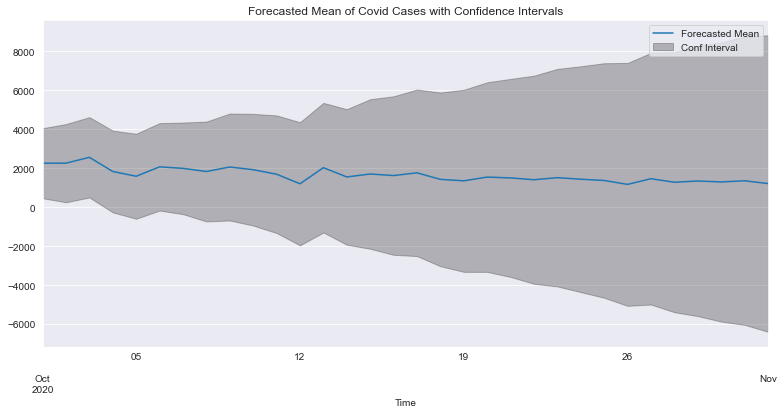

In [12]:
pdq = (2, 1, 4)
pdqs = (2, 0, 0, 7)
#train, test, results = fit_model(ca, ca_test, pdq=pdq, pdqs=pdqs)

model = sm.tsa.statespace.SARIMAX(fl, order=pdq,seasonal_order=pdqs)
fit_model = model.fit()
output = fit_model.get_prediction(start='2020-10-01',end='2020-11-01', dynamic=True)
forecast_ci = output.conf_int()
fig, ax = plt.subplots(figsize=(13,6))
output.predicted_mean.plot(label='Forecasted Mean')
ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
plt.title('Forecasted Mean of Covid Cases with Confidence Intervals')
plt.xlabel('Time')
plt.legend(loc='best');
plt.show()

Once again, the mean estimate predictions are decreasing gradually, just like with California.  Comparing to reality, according to the New York Times, on October 5th, Florida reported **1,415 new cases**. This is pretty close to the prediction generated by the forecast.  However, once again, the forecast becomes uncertain very quickly. 

Let's see if we can make better predictions with LSTMs again.

# LSTM

## Preprocessing

First, we'll preprocess the data and split it into train, validation, and test sets. 

In [6]:
fl_train, fl_val, fl_test = preprocess_data(fl, 'FL_positiveIncrease', scaler)

print(f"Train has {len(fl_train)} values")
print(f"Validation has {len(fl_val)} values")
print(f"Test has {len(fl_test)} values")

Train has 235 values
Validation has 7 values
Test has 14 values


## Reshaping

Just like with California, we're going to reshape the datasets twice.  The first time will be to **reshape the datasets** so that we have **input-output pairs** (X and y, where X = t and y = t + 1).

After that, we'll **reshape the data again** so that they match the LSTM input layer requirements when we fit the model.  They will need to be 3-dimensional and those dimensions will represent the **number of samples**, the **number of time-steps**, and the **number of features**.

In [14]:
look_back = 1

X_train, y_train = create_dataset(fl_train, look_back)
X_val, y_val = create_dataset(fl_val, look_back)
X_test, y_test = create_dataset(fl_test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Fitting Model

With Florida, we're going to just jump straight to changing the `patience` parameter to 100.

In [15]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70,
                   validation_data=(X_val, y_val),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=100)],
                   verbose=1, shuffle=False)

model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 2ms/step - loss: 0.0818 - val_loss: 0.0268
Epoch 2/500
233/233 [==============================] - 0s 69us/step - loss: 0.0767 - val_loss: 0.0231
Epoch 3/500
233/233 [==============================] - 0s 64us/step - loss: 0.0714 - val_loss: 0.0196
Epoch 4/500
233/233 [==============================] - 0s 86us/step - loss: 0.0665 - val_loss: 0.0165
Epoch 5/500
233/233 [==============================] - 0s 64us/step - loss: 0.0625 - val_loss: 0.0137
Epoch 6/500
233/233 [==============================] - 0s 69us/step - loss: 0.0586 - val_loss: 0.0113
Epoch 7/500
233/233 [==============================] - 0s 64us/step - loss: 0.0550 - val_loss: 0.0091
Epoch 8/500
233/233 [==============================] - 0s 60us/step - loss: 0.0525 - val_loss: 0.0073
Epoch 9/500
233/233 [==============================] - 0s 64us/step - loss: 0.0491 - val_loss: 0.0058
Epoch 10/500
233/233 [=================

Epoch 80/500
233/233 [==============================] - 0s 69us/step - loss: 0.0076 - val_loss: 0.0025
Epoch 81/500
233/233 [==============================] - 0s 56us/step - loss: 0.0072 - val_loss: 0.0025
Epoch 82/500
233/233 [==============================] - 0s 69us/step - loss: 0.0072 - val_loss: 0.0026
Epoch 83/500
233/233 [==============================] - 0s 82us/step - loss: 0.0070 - val_loss: 0.0026
Epoch 84/500
233/233 [==============================] - 0s 69us/step - loss: 0.0063 - val_loss: 0.0026
Epoch 85/500
233/233 [==============================] - 0s 56us/step - loss: 0.0071 - val_loss: 0.0026
Epoch 86/500
233/233 [==============================] - 0s 69us/step - loss: 0.0069 - val_loss: 0.0026
Epoch 87/500
233/233 [==============================] - 0s 73us/step - loss: 0.0067 - val_loss: 0.0027
Epoch 88/500
233/233 [==============================] - 0s 69us/step - loss: 0.0065 - val_loss: 0.0027
Epoch 89/500
233/233 [==============================] - 0s 69us/step - lo

## Results


In [16]:
from sklearn.metrics import mean_absolute_error as MAE

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to original scale for interpretation
train_predict = scaler.inverse_transform(train_predict)
y_train_rescaled = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_rescaled = scaler.inverse_transform([y_test])

print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                        train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                               train_predict[:,0])))
print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                       test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                              test_predict[:,0])))

Train Mean Absolute Error: 714.3803523640776
Train Root Mean Squared Error: 1160.0423405867045
Test Mean Absolute Error: 690.9385070800781
Test Root Mean Squared Error: 945.8613674024803


### RMSE

* Train RMSE: 1160.042
* Test RMSE: 945.861

Once again, we're seeing a **significant improvement** in our Training RMSE** and a **decent RMSE** for our testing set.  We'll see if this affects the predictions against our test set.  

First, we'll look at the model loss. 

### Model Loss

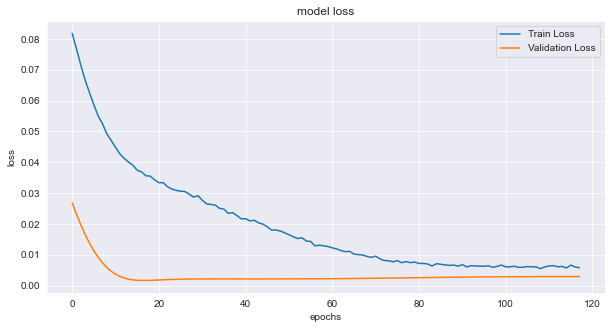

In [17]:
plot_loss(history)

Alright! Both training loss and validation loss seem to have **converged**. Doesn't really look like we need to train for any more epochs.  Let's see how the model's predictions stand up to our test data.

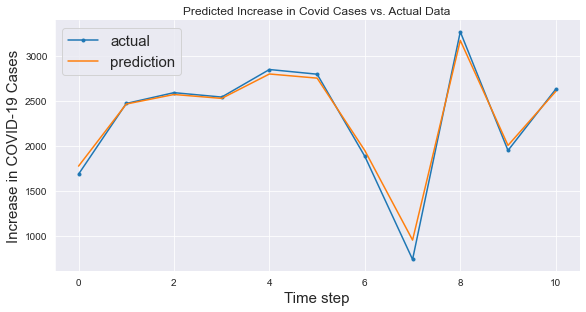

In [18]:
LSTM_prediction_plot(test_predict, y_test_rescaled)

Look how tight that fit is!  Even though the test RMSE is marginally better, the fit is once again, much tighter than with our SARIMA Model.

# Final Statement
Once again, the LSTM model outperforms the SARIMA Model in RMSE and in prediction accuracy.

Our next stop is Georgia!